In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

encoding = "ISO-8859-1"

import Jupyter_module_loader

In [2]:
# you should clone this git to this subdirectory (in some directory - I call it BES_analysis - doesn't matter though)

if os.getcwd().split(os.sep)[-1] != 'BES_analysis_code':
    raise Exception("Stop! You're in the wrong directory - should be in 'BES_analysis_code'")

BES_code_folder   = "../BES_analysis_code/" # we should be here!
BES_small_data_files = BES_code_folder + "small data files" + os.sep
if not os.path.exists( BES_small_data_files ):
    os.makedirs( BES_small_data_files )

# we should create these if they don't already exist
BES_data_folder   = "../BES_analysis_data/"
if not os.path.exists( BES_data_folder ):
    os.makedirs( BES_data_folder )

BES_output_folder = "../BES_analysis_output/"
if not os.path.exists( BES_output_folder ):
    os.makedirs( BES_output_folder )
    
BES_file_manifest = pd.read_csv( BES_small_data_files + "BES_file_manifest.csv" )

BES_R_data_files = BES_data_folder + "R_data" + os.sep
if not os.path.exists( BES_R_data_files ):
    os.makedirs( BES_R_data_files )


In [3]:
dataset_name = "W8_only"

In [4]:
%%time

manifest = BES_file_manifest[ BES_file_manifest["Name"] == dataset_name ]

data_subfolder = BES_data_folder + dataset_name + os.sep

dataset_filename = manifest["Stata_Filename"].values[0]
# dataset_description = manifest["Friendlier_Description"].values[0]
# dataset_citation = manifest["Citation"].values[0]
# dataset_start = manifest["Date_Start"].values[0]
# dataset_stop = manifest["Date_Stop"].values[0]
# dataset_wave = manifest["Wave No"].values[0]

# BES_Panel = pd.read_stata( data_subfolder + dataset_filename )
BES_Panel  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
print("BES_Panel", BES_Panel.shape )

BES_Panel (33502, 455)
Wall time: 348 ms


In [5]:
%%time

BES_numeric = pd.read_hdf( data_subfolder + "BESnumeric.hdf", "BESnumeric" )
print("BES_numeric",  BES_numeric.shape )

var_type    = pd.read_csv( data_subfolder + "var_type.csv", encoding=encoding)
var_type.set_index("Unnamed: 0", inplace=True)
print("var_type",  var_type.shape )

fname = data_subfolder + "cat_dictionary.pkl"
with open(fname, "rb") as f:
    cat_dictionary = pickle.load( f )
    
####

BES_non_numeric = pd.read_hdf( data_subfolder + "BESnon_numeric.hdf", "BESnon_numeric" )
print("BES_non_numeric",  BES_non_numeric.shape )

BES_reduced = pd.read_hdf( data_subfolder + "BES_reduced.hdf", "BES_reduced" )
print("BES_reduced",  BES_reduced.shape )

BES_reduced_with_na = pd.read_hdf( data_subfolder + "BES_reduced_with_na.hdf", "BES_reduced_with_na")
print("BES_reduced_with_na", BES_reduced_with_na.shape )

fname = data_subfolder + "new_old_col_names.pkl"
with open(fname, "rb") as f:
    new_old_col_names = pickle.load(f) 

BES_numeric (33502, 399)
var_type (455, 13)
BES_non_numeric (33502, 51)
BES_reduced (33502, 351)
BES_reduced_with_na (33502, 351)
Wall time: 791 ms


In [6]:
import tensorflow as tf
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import EarlyStopping

In [7]:
# warnings - don't know why, online comments suggest just blocking
tf.logging.set_verbosity(tf.logging.ERROR)

In [8]:
# [x for x in BES_reduced.columns if "euref" in x.lower()]
y = BES_reduced['euRefVote_Leave the EU'].values
X = BES_reduced.drop(['euRefVote_Leave the EU'],axis=1).values

In [9]:
from tensorflow.python.keras.utils import to_categorical
y = to_categorical(y)

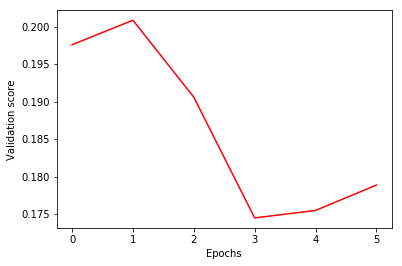

In [10]:
#
early_stopping_monitor = EarlyStopping(patience=2)

# Create the model: model
model = Sequential()

# Add the first hidden layer
input_shape = (X.shape[1],)
model.add( Dense(50, activation='relu', input_shape = input_shape) )

# Add the second hidden layer
model.add( Dense(50, activation='relu') )

# Add the output layer
no_of_outputs = len(np.unique(y))
model.add( Dense( no_of_outputs , activation='softmax') )

# Compile the model
model.compile( optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Fit the model
model_training = model.fit(X, y, epochs=15, validation_split=0.2, callbacks=[early_stopping_monitor], verbose=False)

# Create the plot
plt.plot(model_training.history['val_loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

In [11]:
import shap


In [12]:
from shap.explainers.gradient import GradientExplainer

In [13]:
import shap
from shap.explainers.deep import DeepExplainer
from shap.explainers.gradient import GradientExplainer
# e = DeepExplainer(model,X)

In [14]:
print (shap.__file__)

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\shap\__init__.py


In [15]:
tf.__version__

'1.9.0'

In [14]:
## Deep learning has install issues! Going to create a new environment just for tensorflow


# meh - issue is cpu not set up to use post 1.5 special commands!

# I guess install gpu_ocelot and cuda version???
# lot of work!

In [18]:
e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), X)

In [27]:
f = lambda x: model.predict_proba(x)

In [49]:
explainer = shap.KernelExplainer(f, X[0:-1:100,0:])

Using 336 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


In [50]:
shap_values = explainer.shap_values(X[0:-1:100,0:])
# unspeakably slow!

  8%|███▎                                   | 28/336 [16:56<3:06:21, 36.30s/it]

KeyboardInterrupt: 

In [8]:
import umap

In [9]:
X.shape

(33502, 350)

In [10]:
y = BES_reduced['euRefVote_Leave the EU'].values

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify = y, random_state=42)
X_test.shape

(3351, 350)

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn import datasets, decomposition, manifold, preprocessing
from colorsys import hsv_to_rgb

import umap

<class 'umap.umap_.UMAP'>


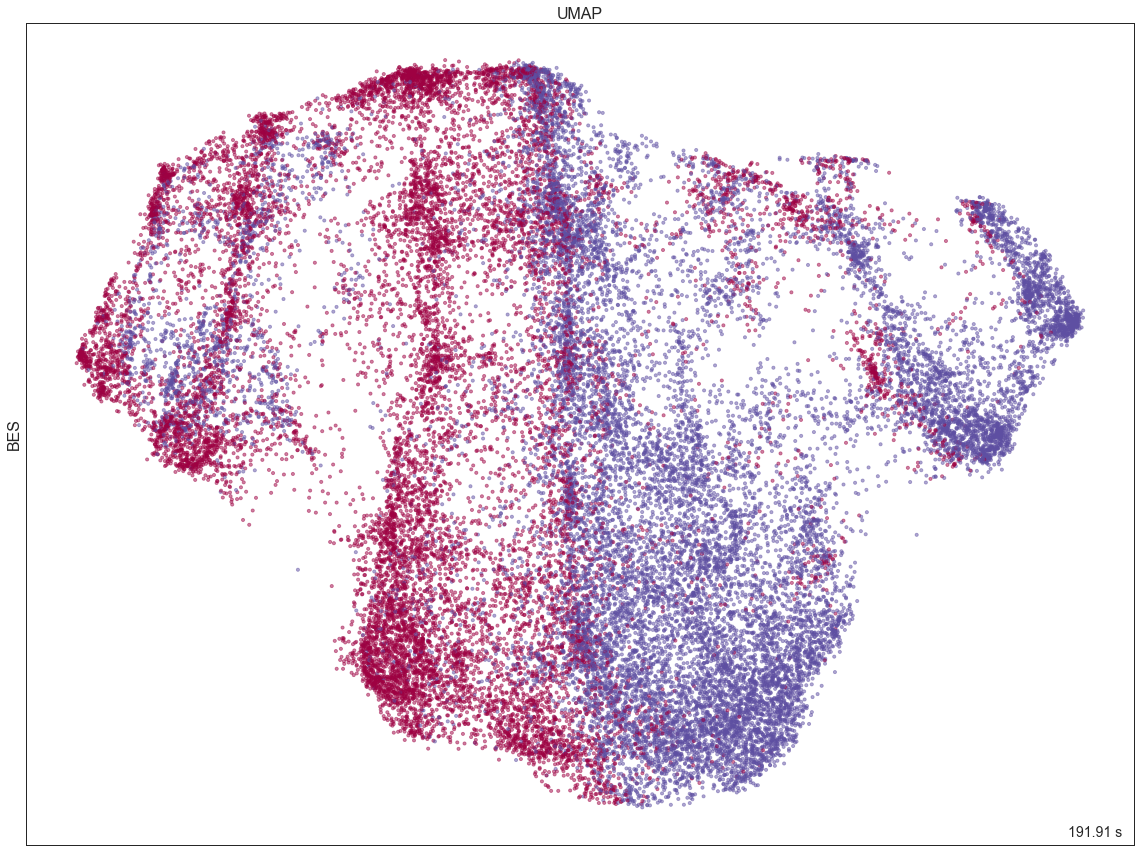

In [24]:


sns.set(context="paper", style="white")

# blobs, blob_labels = datasets.make_blobs(
#     n_samples=500, n_features=10, centers=5, random_state=42
# )
# iris = datasets.load_iris()
# digits = datasets.load_digits(n_class=10)
# wine = datasets.load_wine()
# swissroll, swissroll_labels = datasets.make_swiss_roll(
#     n_samples=1000, noise=0.1, random_state=42
# )
# sphere = np.random.normal(size=(600, 3))
# sphere = preprocessing.normalize(sphere)
# sphere_hsv = np.array(
#     [
#         (
#             (np.arctan2(c[1], c[0]) + np.pi) / (2 * np.pi),
#             np.abs(c[2]),
#             min((c[2] + 1.1), 1.0),
#         )
#         for c in sphere
#     ]
# )
# sphere_colors = np.array([hsv_to_rgb(*c) for c in sphere_hsv])

reducers = [
#      (manifold.TSNE, {"perplexity": 50}),
    # (manifold.LocallyLinearEmbedding, {'n_neighbors':10, 'method':'hessian'}),
#     (manifold.Isomap, {"n_neighbors": 30}),
#     (manifold.MDS, {}),
#     (decomposition.PCA, {}),
    (umap.UMAP, {"n_neighbors": 15, "min_dist": 0.001}),
]

test_data = [
#     (blobs, blob_labels),
#     (iris.data, iris.target),
#     (digits.data, digits.target),
#     (wine.data, wine.target),
#     (swissroll, swissroll_labels),
#     (sphere, sphere_colors),
#     (X_test, y_test)
      (X, y)
]
# dataset_names = ["Blobs", "Iris", "Digits", "Wine", "Swiss Roll", "Sphere"]
dataset_names = ["BES"]

n_rows = len(test_data)
n_cols = len(reducers)
ax_index = 1
ax_list = []

# plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.figure(figsize=(16, 12))
plt.subplots_adjust(
    left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01
)
for data, labels in test_data:
    for reducer, args in reducers:
        print(reducer)
        start_time = time.time()
        embedding = reducer(n_components=2, **args).fit_transform(data)
        elapsed_time = time.time() - start_time
        ax = plt.subplot(n_rows, n_cols, ax_index)
        if isinstance(labels[0], tuple):
            ax.scatter(*embedding.T, s=10, c=labels, alpha=0.5)
        else:
            ax.scatter(
                *embedding.T, s=10, c=labels, cmap="Spectral", alpha=0.5
            )
        ax.text(
            0.99,
            0.01,
            "{:.2f} s".format(elapsed_time),
            transform=ax.transAxes,
            size=14,
            horizontalalignment="right",
        )
        ax_list.append(ax)
        ax_index += 1
plt.setp(ax_list, xticks=[], yticks=[])

for i in np.arange(n_rows) * n_cols:
    ax_list[i].set_ylabel(dataset_names[i // n_cols], size=16)
for i in range(n_cols):
    ax_list[i].set_xlabel(repr(reducers[i][0]()).split("(")[0], size=16)
    ax_list[i].xaxis.set_label_position("top")

plt.tight_layout()
plt.show()

In [61]:
def draw_umap(data, labels, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    start_time = time.time()
    u = fit.fit_transform(data);
    elapsed_time = time.time() - start_time   
    
    
    
    fig = plt.figure(figsize=(16, 12))
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), s=10, c=labels, cmap="Spectral", alpha=0.5)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], s=10, c=labels, cmap="Spectral", alpha=0.5)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], s=100, c=labels, cmap="Spectral", alpha=0.5)
        
    ax.text(
        0.99,
        0.01,
        "{:.2f} s".format(elapsed_time),
        transform=ax.transAxes,
        size=14,
        horizontalalignment="right",
    )        
    plt.title(title, fontsize=18)
    return fit, u

def fit_umap(data, labels=[], n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    start_time = time.time()
    if len(labels)!=0:
        u = fit.fit_transform(data,labels);
    else:
        u = fit.fit_transform(data);
    elapsed_time = time.time() - start_time
    return fit, u, elapsed_time

def draw_fitted_umap(u, elapsed_time, labels, label_strings=None, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fig = plt.figure(figsize=(16, 12))
    if n_components == 1:
        ax = fig.add_subplot(111)
        sc = ax.scatter(u[:,0], range(len(u)), s=10, c=labels, cmap="Spectral", alpha=0.5, label = label_strings)
    if n_components == 2:
        ax = fig.add_subplot(111)
        unique = list(set(labels))
        colors = [plt.cm.nipy_spectral(float(i)/max(unique)) for i in unique]    

        for lab in range(0,np.max(labels)+1):
            ax.scatter(u[labels==lab,0], u[labels==lab,1], s=10, c=colors[lab], alpha=0.5, label = label_strings[lab])
            
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        sc = ax.scatter(u[:,0], u[:,1], u[:,2], s=100, c=labels, cmap="Spectral", alpha=0.5, label = label_strings)
        
#     if len(label_strings) != 0:
#         ax.legend()
#     else:
#         fig.colorbar(sc,ax=ax)
    ax.text(
        0.99,
        0.01,
        "{:.2f} s".format(elapsed_time),
        transform=ax.transAxes,
        size=14,
        horizontalalignment="right",
    )        
    plt.title(title, fontsize=18)
    ax.legend()
    return ax


# def draw_fitted_umap_with_labels(u, elapsed_time, labels, label_strings=None,
#                                  n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    



In [30]:
fit, u, elapsed_time = fit_umap(X, y)

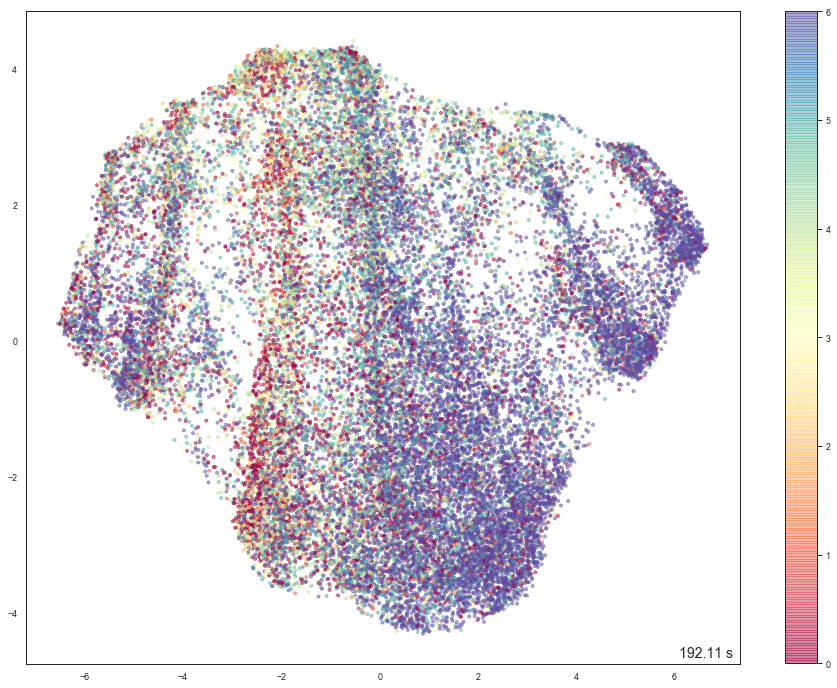

In [50]:
# englishness__Very strongly English
draw_fitted_umap(u, elapsed_time, BES_reduced['englishness__Very strongly English'].values)


In [91]:
X2 = np.zeros((X[[0,1],:]).shape)

In [92]:
X2.shape

(2, 350)

In [78]:
X.shape

(33502, 350)

In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

var_name = "euRefVote"
drop_vars = [x for x in BES_reduced.columns if var_name in x]
X = BES_reduced.drop(drop_vars,axis=1).values
y = BES_Panel[var_name].cat.codes

X_std = scaler.fit_transform(X)
fit, u, elapsed_time = fit_umap(X_std, y, n_neighbors=30, min_dist=0.2, n_components=2, metric='euclidean', title='')
print(elapsed_time)

571.2446732521057


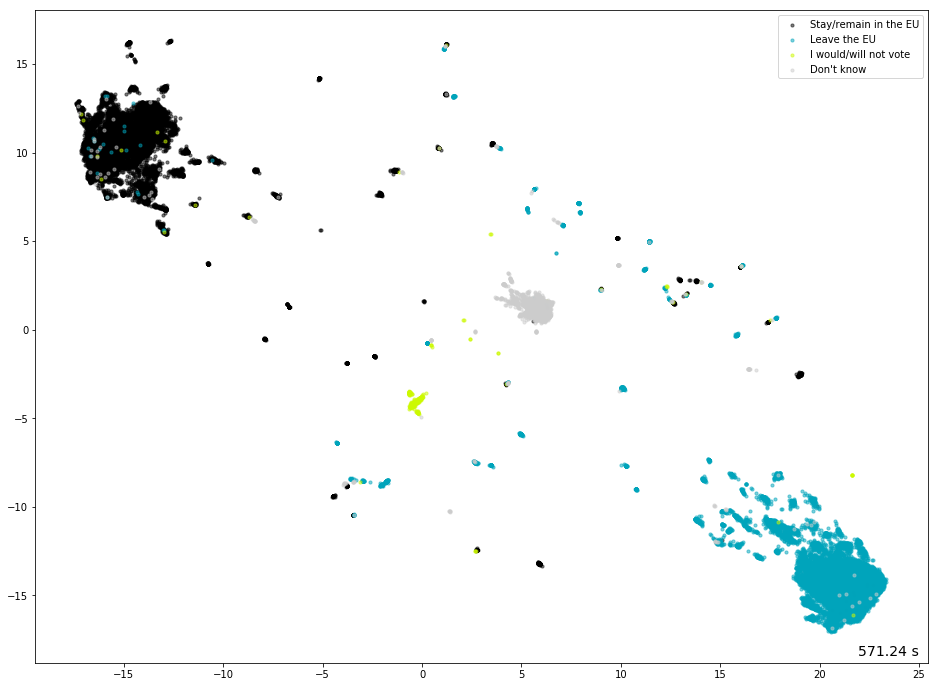

In [66]:
# draw_fitted_umap(u, elapsed_time, labels, label_strings=None
label_strings=BES_Panel[var_name].cat.categories
draw_fitted_umap(u, elapsed_time, y, label_strings)

In [67]:
df_u = pd.DataFrame(u)
df_u_0_corr = BES_reduced.drop(drop_vars,axis=1).corrwith(df_u[0])
df_u_0_corr.sort_values()

euUKRich__Strongly agree                                       -0.641598
euLawsLevel__Strongly agree                                    -0.626220
euPreventWar__Strongly agree                                   -0.590459
euLeaveBigBusiness__Much more likely                           -0.579168
euCloser__Strongly agree                                       -0.560206
europeanness__Very strongly European                           -0.557471
immigSelf__Allow many more                                     -0.554180
immigCultural__Enriches cultural life                          -0.547763
echr__Strongly agree                                           -0.537872
satDemEU__Very satisfied                                       -0.533632
immigEcon__Good for economy                                    -0.530992
euMore__Many more                                              -0.518729
effectsEUUnemployment__Much higher                             -0.506428
normEU__Strongly agree                             

In [68]:
df_u_1_corr = BES_reduced.drop(drop_vars,axis=1).corrwith(df_u[1])
df_u_1_corr.sort_values()


EUIntegrationSelf__Protect our independence                    -0.700133
euUndermineIdentity__Strongly agree                            -0.659052
effectsEUEcon__Much better                                     -0.646259
likeUKIP__Strongly like                                        -0.612907
ukCoopMovement__Bad for Britain                                -0.608216
UKsovereignty__Strongly agree                                  -0.593916
euLeaveVoice__Much higher                                      -0.578424
euParlOverRide__Strongly agree                                 -0.576770
likeFarage__Strongly like                                      -0.574551
effectsEUTrade__Much higher                                    -0.568247
effectsEUNHS__Much better                                      -0.563643
ukCoopWorkers__Bad for Britain                                 -0.537144
effectsEUWorkers__Much better                                  -0.536470
socialIdentityGlobalLeave__A great deal in common  

In [114]:
fit, u, elapsed_time = fit_umap(X, BES_reduced['euRefVote_Leave the EU'].values)

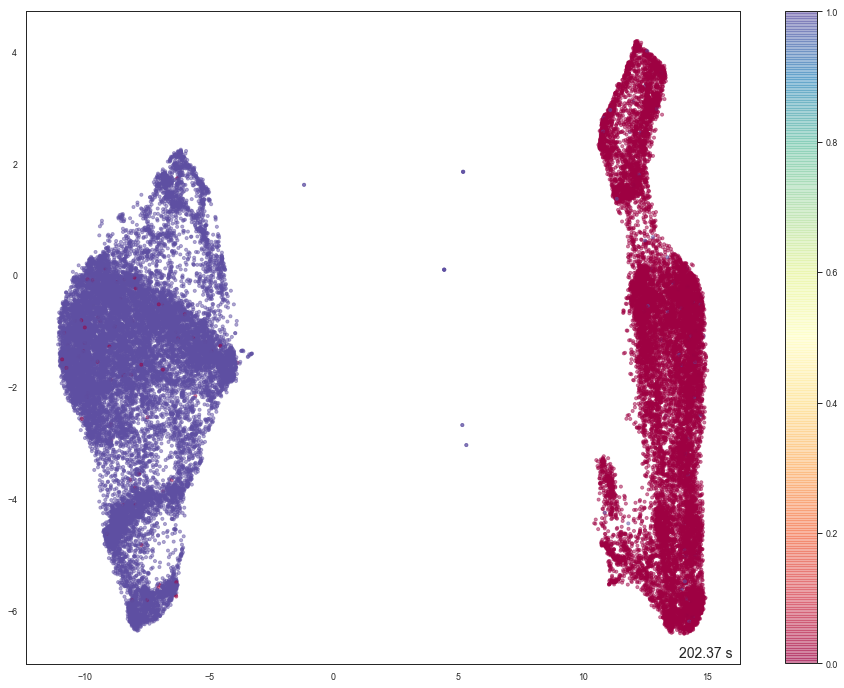

In [115]:
draw_fitted_umap(u, elapsed_time, BES_reduced['euRefVote_Leave the EU'].values)

In [126]:
df_u = pd.DataFrame(u)
df_u_0_corr = BES_reduced.drop(['euRefVote_Leave the EU'],axis=1).corrwith(df_u[0])
df_u_0_corr.sort_values()
# euRef standard split

In [129]:
df_u_1_corr = BES_reduced.drop(['euRefVote_Leave the EU'],axis=1).corrwith(df_u[1])
df_u_1_corr.sort_values()


euRefExpectation__100 - UK will definitely vote to leave the EU       -0.729003
socialIdentityGlobalLeave__A great deal in common                     -0.147485
partyIdEU__Mainly leave                                               -0.147327
likeUKIP__Strongly like                                               -0.135997
generalElectionVote_United Kingdom Independence Party (UKIP)          -0.133298
likeFarage__Strongly like                                             -0.127731
campaigninfoLeave__Strongly agree                                     -0.123048
partyId_United Kingdom Independence Party (UKIP)                      -0.121997
bestOnMII_United Kingdom Independence Party (UKIP)                    -0.117194
parliamentSupport__Mainly leave                                       -0.116690
likeBoris__Strongly like                                              -0.116546
businessSupport__Mainly leave                                         -0.115178
marital_Never married                   

In [135]:
# try another variable

[x for x in BES_reduced.columns if "generalElection" in x]

['generalElectionVote_Conservative',
 'generalElectionVote_United Kingdom Independence Party (UKIP)',
 'generalElectionVote_Liberal Democrat',
 'generalElectionVote_Scottish National Party (SNP)',
 'generalElectionVote_Green Party',
 'generalElectionVote_Plaid Cymru']

In [53]:
var_name = "generalElectionVote"
drop_vars = [x for x in BES_reduced.columns if var_name in x]
X = BES_reduced.drop(drop_vars,axis=1).values
y = BES_Panel[var_name].cat.codes

fit, u, elapsed_time = fit_umap(X, y, n_neighbors=10, min_dist=0.01, n_components=2, metric='euclidean', title='')

0
1
2
3
4
5
6
7
8
9


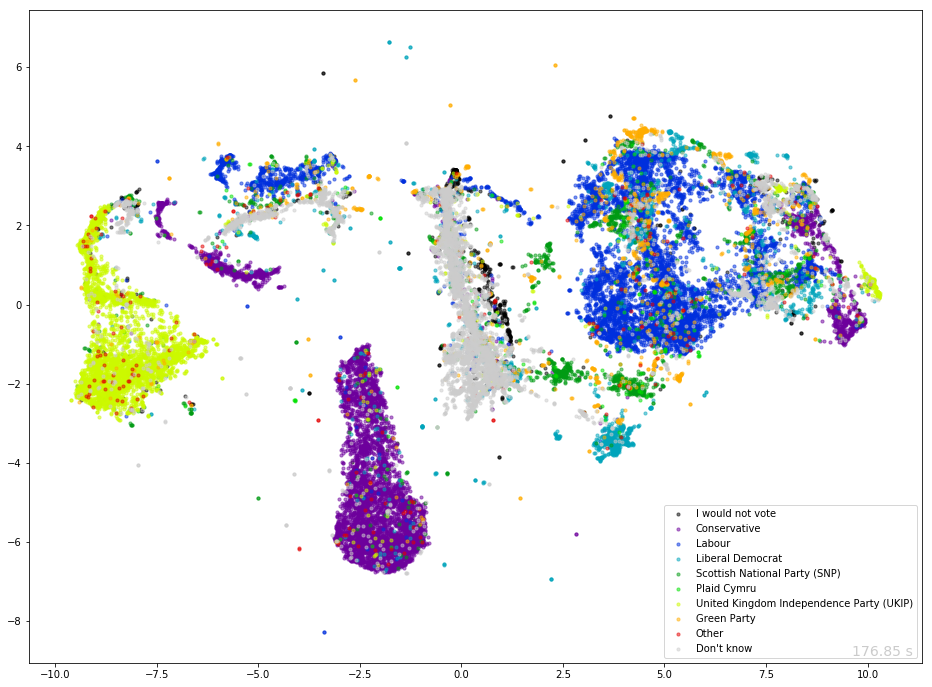

In [54]:
var_name = "generalElectionVote"
title = ""
n_components == 2
label_strings=BES_Panel[var_name].cat.categories
labels = y

fig = plt.figure(figsize=(16, 12))
if n_components == 1:
    ax = fig.add_subplot(111)
    sc = ax.scatter(u[:,0], range(len(u)), s=10, c=labels, cmap="Spectral", alpha=0.5, label = label_strings)
if n_components == 2:
    ax = fig.add_subplot(111)
    
    unique = list(set(labels))
    colors = [plt.cm.nipy_spectral(float(i)/max(unique)) for i in unique]    
    
    for lab in range(0,np.max(labels)+1):
        ax.scatter(u[labels==lab,0], u[labels==lab,1], s=10, c=colors[lab], alpha=0.5, label = label_strings[lab])
if n_components == 3:
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(u[:,0], u[:,1], u[:,2], s=100, c=labels, cmap="Spectral", alpha=0.5, label = label_strings)

#     if len(label_strings) != 0:
#         ax.legend()
#     else:
#         fig.colorbar(sc,ax=ax)
ax.text(
    0.99,
    0.01,
    "{:.2f} s".format(elapsed_time),
    transform=ax.transAxes,
    size=14,
    horizontalalignment="right",
);
plt.title(title, fontsize=18);


ax.legend();

In [51]:
df_u = pd.DataFrame(u)
df_u_0_corr = BES_reduced.drop(drop_vars,axis=1).corrwith(df_u[0])
df_u_0_corr.sort_values()

likeUKIP__Strongly like                                           -0.673759
likeFarage__Strongly like                                         -0.628469
EUIntegrationSelf__Protect our independence                       -0.569303
likeBoris__Strongly like                                          -0.547766
euRefExpectation__100 - UK will definitely vote to leave the EU   -0.547009
euUndermineIdentity__Strongly agree                               -0.546118
euRefVote_Leave the EU                                            -0.538980
partyIdEU__Mainly leave                                           -0.530369
euParlOverRide__Strongly agree                                    -0.520729
bestOnMII_United Kingdom Independence Party (UKIP)                -0.519852
UKsovereignty__Strongly agree                                     -0.511107
likeGove__Strongly like                                           -0.499011
immigrantsWelfareState__Strongly agree                            -0.498802
ukCoopMoveme

In [52]:
df_u_1_corr = BES_reduced.drop(drop_vars,axis=1).corrwith(df_u[1])
df_u_1_corr.sort_values()


likeCon__Strongly like                          -0.633277
partyId_Conservative                            -0.630888
likeCameron__Strongly like                      -0.572096
likeOsborne__Strongly like                      -0.493767
profile_past_vote_2005_Conservative Party       -0.463427
age                                             -0.383904
pccVote1_The Conservative candidate             -0.364564
likeGove__Strongly like                         -0.353201
changeEconomy__Getting a lot better             -0.328409
monarch__Strongly agree                         -0.317361
likeBoris__Strongly like                        -0.299568
satDemUK__Very satisfied                        -0.281709
changeNHS__Getting a lot better                 -0.260780
UKsovereignty__Strongly agree                   -0.258418
euParlOverRide__Strongly agree                  -0.257194
changeEducation__Getting a lot better           -0.255568
euMemberJoin__Strongly agree                    -0.241769
euRedTape__Str